# Comprehensive Model Evaluation

Evaluates all trained models (CAE, VAE, DAE) and generates a comprehensive metrics report including:
- **Image-level**: ROC-AUC, AP, Precision, Recall, F1
- **Pixel-level**: Pixel AUC, IoU, Dice
- **Visualizations**: Bar charts, heatmaps, and comparisons

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, 'F:/Thesis')

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from src.config import DEVICE, MVTEC_CATEGORIES, MODELS_DIR, OUTPUTS_DIR
from src.data import create_mvtec_dataloaders
from src.models import create_cae, create_vae, create_denoising_ae
from src.evaluation import (
    compute_roc_auc,
    compute_average_precision,
    find_optimal_threshold,
    compute_iou,
    compute_dice,
    compute_pixel_auc,
)

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print(f"Device: {DEVICE}")
print(f"Categories: {len(MVTEC_CATEGORIES)}")

Device: cpu
Categories: 15


## Helper Functions

In [2]:
def load_model(model_type: str, category: str):
    """Load a trained model."""
    model_path = MODELS_DIR / f"{model_type.lower()}_{category}_final.pth"
    
    if not model_path.exists():
        return None
    
    if model_type.upper() == "CAE":
        model = create_cae()
    elif model_type.upper() == "VAE":
        model = create_vae()
    elif model_type.upper() == "DAE":
        model = create_denoising_ae()
    else:
        return None
    
    checkpoint = torch.load(model_path, map_location=DEVICE, weights_only=False)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    model.to(DEVICE)
    
    return model


def evaluate_category(model, dataloader):
    """Evaluate model on a single category."""
    model.eval()
    
    all_labels, all_scores = [], []
    all_pred_masks, all_gt_masks = [], []
    
    with torch.no_grad():
        for batch in dataloader:
            if len(batch) == 3:
                images, masks, labels = batch
            else:
                images, labels = batch
                masks = None
            
            images = images.to(DEVICE)
            scores = model.get_anomaly_score(images)
            all_scores.extend(scores.cpu().numpy())
            all_labels.extend(labels.numpy())
            
            if masks is not None:
                anomaly_maps = model.get_anomaly_map(images)
                for i in range(len(images)):
                    pred_map = anomaly_maps[i, 0].cpu().numpy()
                    pred_map = (pred_map - pred_map.min()) / (pred_map.max() - pred_map.min() + 1e-8)
                    all_pred_masks.append(pred_map)
                    all_gt_masks.append(masks[i].numpy())
    
    all_labels = np.array(all_labels)
    all_scores = np.array(all_scores)
    
    metrics = {}
    
    # Image-level
    if len(np.unique(all_labels)) > 1:
        metrics['image_auc'] = compute_roc_auc(all_labels, all_scores)
        metrics['image_ap'] = compute_average_precision(all_labels, all_scores)
        threshold, tm = find_optimal_threshold(all_labels, all_scores)
        metrics['threshold'] = threshold
        metrics['precision'] = tm['precision']
        metrics['recall'] = tm['recall']
        metrics['f1'] = tm['f1']
    else:
        metrics = {'image_auc': 0.5, 'image_ap': 0.0, 'threshold': 0.5,
                   'precision': 0.0, 'recall': 0.0, 'f1': 0.0}
    
    # Pixel-level
    if all_pred_masks:
        try:
            metrics['pixel_auc'] = compute_pixel_auc(all_pred_masks, all_gt_masks)
        except:
            metrics['pixel_auc'] = 0.5
        
        ious, dices = [], []
        for pred, gt in zip(all_pred_masks, all_gt_masks):
            if gt.max() > 0:
                ious.append(compute_iou(pred, gt))
                dices.append(compute_dice(pred, gt))
        metrics['mean_iou'] = np.mean(ious) if ious else 0.0
        metrics['mean_dice'] = np.mean(dices) if dices else 0.0
    
    return metrics

## Run Evaluation

In [3]:
results = []
model_types = ["CAE", "VAE", "DAE"]

for model_type in model_types:
    print(f"\n📊 Evaluating {model_type}...")
    
    for category in tqdm(MVTEC_CATEGORIES, desc=model_type):
        model = load_model(model_type, category)
        if model is None:
            continue
        
        try:
            _, test_loader = create_mvtec_dataloaders(category, batch_size=8, return_mask=True)
            metrics = evaluate_category(model, test_loader)
            metrics['model'] = model_type
            metrics['category'] = category
            results.append(metrics)
        except Exception as e:
            print(f"  Error: {category} - {e}")

print("\n✓ Evaluation complete!")


📊 Evaluating CAE...


CAE:   0%|          | 0/15 [00:00<?, ?it/s]


📊 Evaluating VAE...


VAE:   0%|          | 0/15 [00:00<?, ?it/s]


📊 Evaluating DAE...


DAE:   0%|          | 0/15 [00:00<?, ?it/s]


✓ Evaluation complete!


## Results Table

In [4]:
df = pd.DataFrame(results)

# Reorder columns
cols = ['model', 'category', 'image_auc', 'image_ap', 'precision', 'recall', 'f1']
if 'pixel_auc' in df.columns:
    cols.extend(['pixel_auc', 'mean_iou', 'mean_dice'])
df = df[cols]

# Display with styling
df.style.format({'image_auc': '{:.3f}', 'image_ap': '{:.3f}', 'precision': '{:.3f}',
                 'recall': '{:.3f}', 'f1': '{:.3f}', 'pixel_auc': '{:.3f}',
                 'mean_iou': '{:.3f}', 'mean_dice': '{:.3f}'}).background_gradient(cmap='RdYlGn', subset=['image_auc', 'f1'])

,model,category,image_auc,image_ap,precision,recall,f1,pixel_auc,mean_iou,mean_dice
0,CAE,bottle,0.550,0.827,0.759,1.000,0.863,0.606,0.003,0.006
1,CAE,cable,0.458,0.613,0.613,1.000,0.760,0.606,0.000,0.001
2,CAE,capsule,0.477,0.804,0.826,1.000,0.905,0.743,0.004,0.006
3,CAE,carpet,0.330,0.665,0.761,1.000,0.864,0.538,0.000,0.001
4,CAE,grid,0.779,0.917,0.806,0.947,0.871,0.616,0.002,0.004
5,CAE,hazelnut,0.877,0.930,0.802,0.929,0.861,0.866,0.059,0.099
6,CAE,leather,0.447,0.753,0.742,1.000,0.852,0.662,0.020,0.039
7,CAE,metal_nut,0.268,0.702,0.809,1.000,0.894,0.748,0.001,0.001
8,CAE,pill,0.751,0.935,0.875,0.993,0.930,0.500,0.040,0.068
9,CAE,screw,0.979,0.993,0.950,0.966,0.958,0.500,0.000,0.001


## 📊 Visualization: Model Comparison Bar Chart

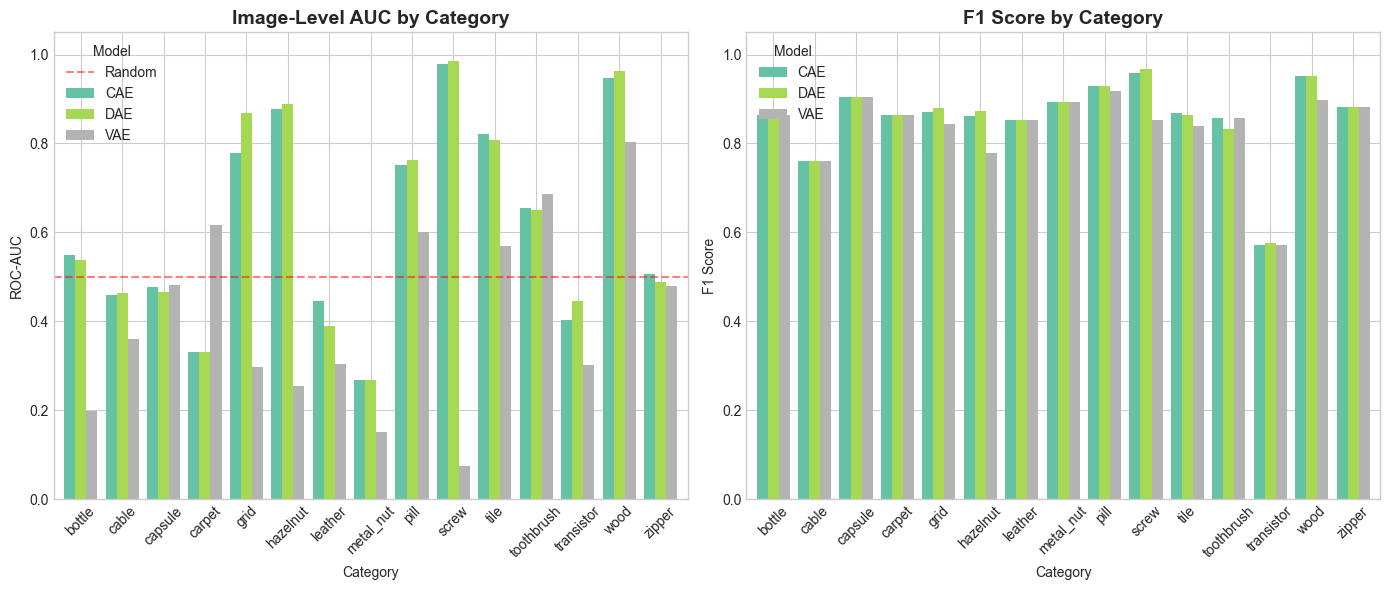

✓ Saved: evaluation_bar_comparison.png


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Image AUC by Category
pivot_auc = df.pivot(index='category', columns='model', values='image_auc')
pivot_auc.plot(kind='bar', ax=axes[0], width=0.8, colormap='Set2')
axes[0].set_title('Image-Level AUC by Category', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('ROC-AUC')
axes[0].set_ylim(0, 1.05)
axes[0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random')
axes[0].legend(title='Model')
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: F1 Score by Category
pivot_f1 = df.pivot(index='category', columns='model', values='f1')
pivot_f1.plot(kind='bar', ax=axes[1], width=0.8, colormap='Set2')
axes[1].set_title('F1 Score by Category', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('F1 Score')
axes[1].set_ylim(0, 1.05)
axes[1].legend(title='Model')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(OUTPUTS_DIR / 'figures' / 'evaluation_bar_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: evaluation_bar_comparison.png")

## 📊 Visualization: AUC Heatmap

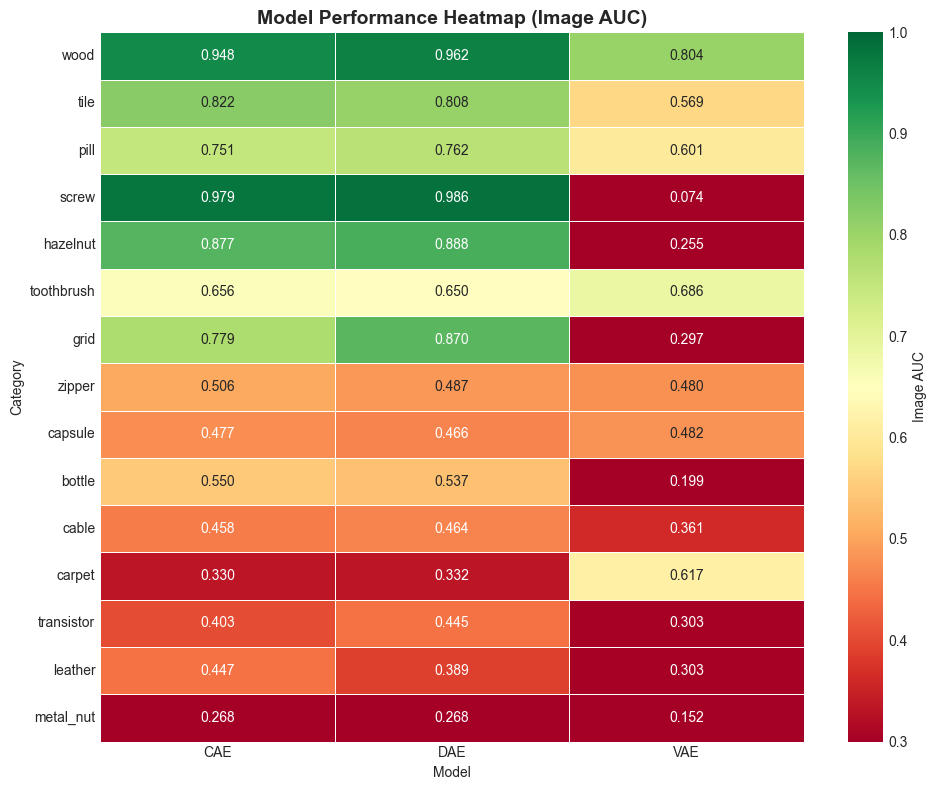

✓ Saved: evaluation_heatmap.png


In [6]:
fig, ax = plt.subplots(figsize=(10, 8))

# Create heatmap data
heatmap_data = df.pivot(index='category', columns='model', values='image_auc')

# Sort by mean AUC
heatmap_data['mean'] = heatmap_data.mean(axis=1)
heatmap_data = heatmap_data.sort_values('mean', ascending=False)
heatmap_data = heatmap_data.drop('mean', axis=1)

sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', 
            vmin=0.3, vmax=1.0, linewidths=0.5, ax=ax,
            cbar_kws={'label': 'Image AUC'})

ax.set_title('Model Performance Heatmap (Image AUC)', fontsize=14, fontweight='bold')
ax.set_xlabel('Model')
ax.set_ylabel('Category')

plt.tight_layout()
plt.savefig(OUTPUTS_DIR / 'figures' / 'evaluation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: evaluation_heatmap.png")

## 📊 Visualization: Mean Performance Comparison

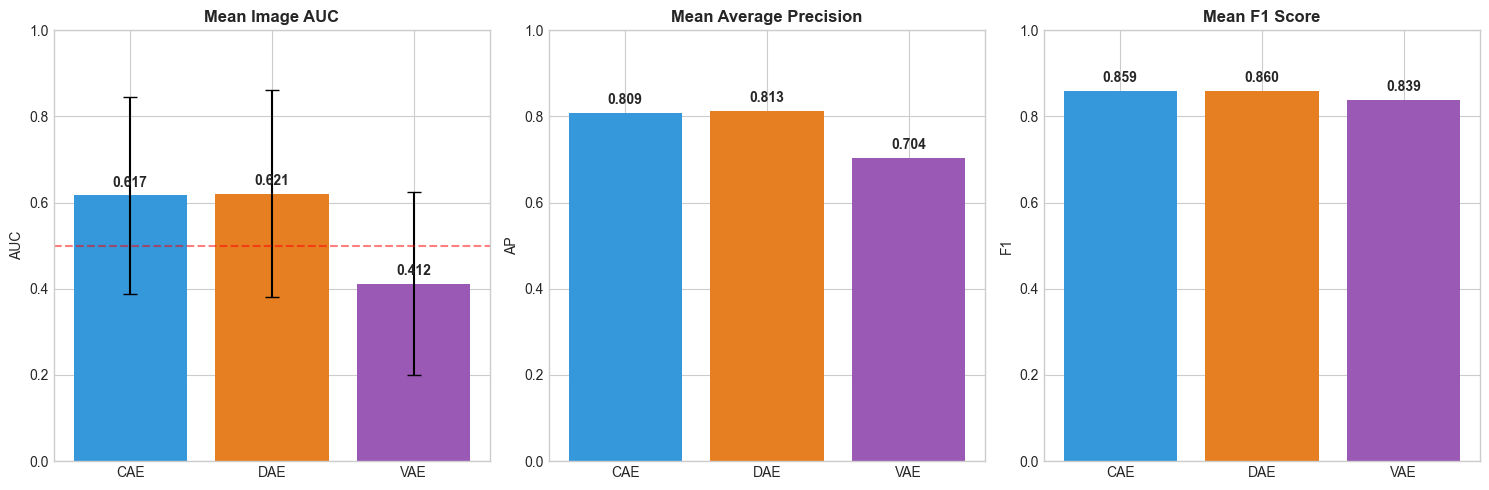

✓ Saved: evaluation_mean_performance.png


In [7]:
# Compute summary stats
summary = df.groupby('model').agg({
    'image_auc': ['mean', 'std'],
    'image_ap': 'mean',
    'precision': 'mean',
    'recall': 'mean',
    'f1': 'mean',
}).round(4)

# Flatten column names
summary.columns = ['_'.join(col).strip('_') for col in summary.columns]
summary = summary.reset_index()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Colors for models
colors = {'CAE': '#3498db', 'VAE': '#9b59b6', 'DAE': '#e67e22'}

# Plot 1: Mean AUC with error bars
bars = axes[0].bar(summary['model'], summary['image_auc_mean'], 
                   yerr=summary['image_auc_std'], capsize=5,
                   color=[colors[m] for m in summary['model']])
axes[0].set_title('Mean Image AUC', fontsize=12, fontweight='bold')
axes[0].set_ylabel('AUC')
axes[0].set_ylim(0, 1)
axes[0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5)
for bar, val in zip(bars, summary['image_auc_mean']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f'{val:.3f}', ha='center', fontweight='bold')

# Plot 2: Mean AP
bars = axes[1].bar(summary['model'], summary['image_ap_mean'],
                   color=[colors[m] for m in summary['model']])
axes[1].set_title('Mean Average Precision', fontsize=12, fontweight='bold')
axes[1].set_ylabel('AP')
axes[1].set_ylim(0, 1)
for bar, val in zip(bars, summary['image_ap_mean']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{val:.3f}', ha='center', fontweight='bold')

# Plot 3: Mean F1
bars = axes[2].bar(summary['model'], summary['f1_mean'],
                   color=[colors[m] for m in summary['model']])
axes[2].set_title('Mean F1 Score', fontsize=12, fontweight='bold')
axes[2].set_ylabel('F1')
axes[2].set_ylim(0, 1)
for bar, val in zip(bars, summary['f1_mean']):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{val:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUTS_DIR / 'figures' / 'evaluation_mean_performance.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: evaluation_mean_performance.png")

## 📊 Visualization: Radar Chart (Multi-Metric)

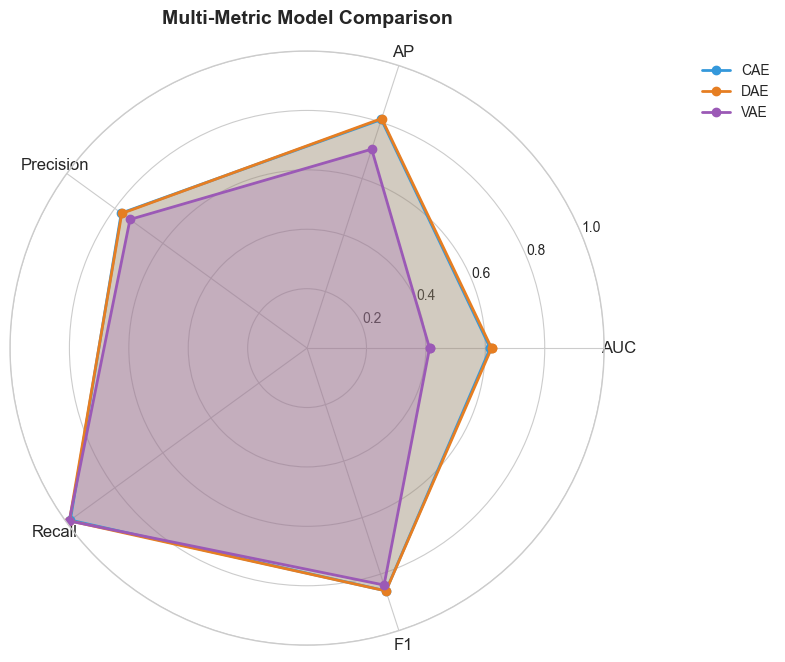

✓ Saved: evaluation_radar.png


In [8]:
from math import pi

# Prepare data
metrics_for_radar = ['image_auc', 'image_ap', 'precision', 'recall', 'f1']
radar_data = df.groupby('model')[metrics_for_radar].mean()

# Number of variables
N = len(metrics_for_radar)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Complete the loop

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

colors = {'CAE': '#3498db', 'VAE': '#9b59b6', 'DAE': '#e67e22'}

for model in radar_data.index:
    values = radar_data.loc[model].values.tolist()
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, 'o-', linewidth=2, label=model, color=colors[model])
    ax.fill(angles, values, alpha=0.25, color=colors[model])

# Labels
labels = ['AUC', 'AP', 'Precision', 'Recall', 'F1']
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, size=12)
ax.set_ylim(0, 1)
ax.set_title('Multi-Metric Model Comparison', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.savefig(OUTPUTS_DIR / 'figures' / 'evaluation_radar.png', dpi=150, bbox_inches='tight')
plt.show()
print("✓ Saved: evaluation_radar.png")

## 📊 Visualization: Pixel-Level Metrics (if available)

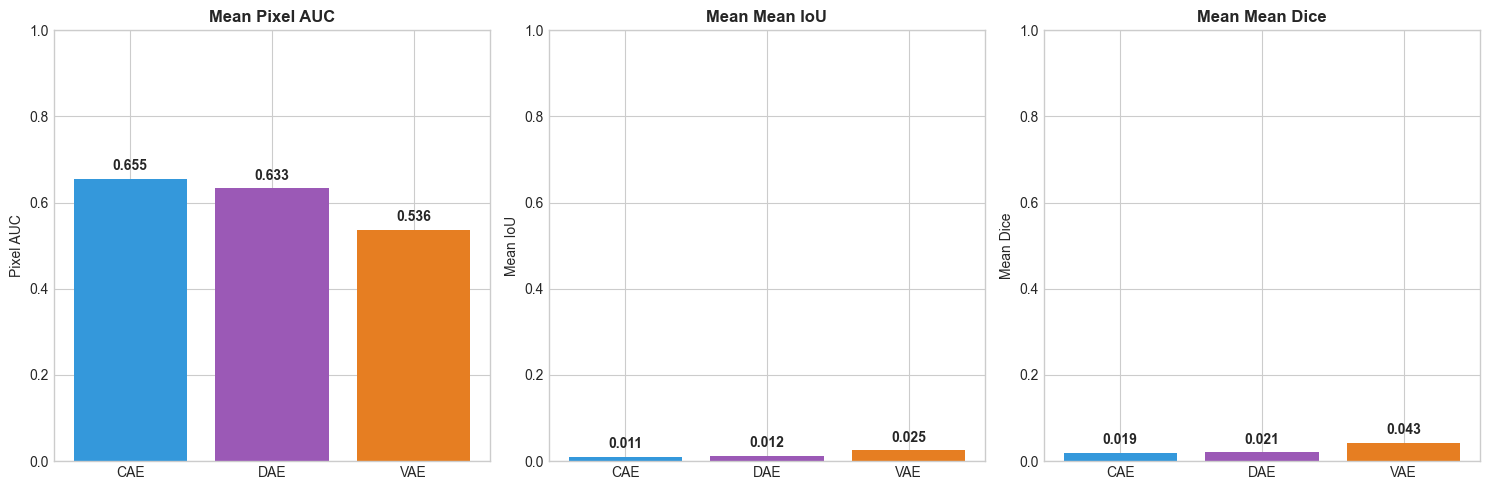

✓ Saved: evaluation_pixel_metrics.png


In [9]:
if 'pixel_auc' in df.columns:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    pixel_summary = df.groupby('model')[['pixel_auc', 'mean_iou', 'mean_dice']].mean()
    
    colors = ['#3498db', '#9b59b6', '#e67e22']
    
    for idx, (metric, title) in enumerate([('pixel_auc', 'Pixel AUC'), 
                                            ('mean_iou', 'Mean IoU'), 
                                            ('mean_dice', 'Mean Dice')]):
        bars = axes[idx].bar(pixel_summary.index, pixel_summary[metric], color=colors)
        axes[idx].set_title(f'Mean {title}', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel(title)
        axes[idx].set_ylim(0, 1)
        for bar, val in zip(bars, pixel_summary[metric]):
            axes[idx].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                          f'{val:.3f}', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(OUTPUTS_DIR / 'figures' / 'evaluation_pixel_metrics.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Saved: evaluation_pixel_metrics.png")
else:
    print("⚠ Pixel-level metrics not available")

## Summary & Save

In [10]:
# Summary table
print("\n" + "="*60)
print("  SUMMARY BY MODEL")
print("="*60)

for model in model_types:
    model_df = df[df['model'] == model]
    if len(model_df) == 0:
        continue
    
    print(f"\n🔹 {model}:")
    print(f"   Image AUC:  {model_df['image_auc'].mean():.4f} ± {model_df['image_auc'].std():.4f}")
    print(f"   Image AP:   {model_df['image_ap'].mean():.4f}")
    print(f"   Precision:  {model_df['precision'].mean():.4f}")
    print(f"   Recall:     {model_df['recall'].mean():.4f}")
    print(f"   F1:         {model_df['f1'].mean():.4f}")
    if 'pixel_auc' in model_df.columns:
        print(f"   Pixel AUC:  {model_df['pixel_auc'].mean():.4f}")
        print(f"   Mean IoU:   {model_df['mean_iou'].mean():.4f}")

# Save
df.to_csv(OUTPUTS_DIR / 'comprehensive_metrics_report.csv', index=False)
print(f"\n📁 Results saved to: {OUTPUTS_DIR / 'comprehensive_metrics_report.csv'}")


  SUMMARY BY MODEL

🔹 CAE:
   Image AUC:  0.6167 ± 0.2293
   Image AP:   0.8092
   Precision:  0.7731
   Recall:     0.9850
   F1:         0.8593
   Pixel AUC:  0.6547
   Mean IoU:   0.0106

🔹 VAE:
   Image AUC:  0.4123 ± 0.2126
   Image AP:   0.7040
   Precision:  0.7367
   Recall:     0.9900
   F1:         0.8386
   Pixel AUC:  0.5363
   Mean IoU:   0.0253

🔹 DAE:
   Image AUC:  0.6210 ± 0.2397
   Image AP:   0.8126
   Precision:  0.7711
   Recall:     0.9888
   F1:         0.8595
   Pixel AUC:  0.6332
   Mean IoU:   0.0118

📁 Results saved to: F:\Thesis\outputs\comprehensive_metrics_report.csv


## Best & Worst Categories

In [11]:
print("\n" + "="*60)
print("  BEST & WORST CATEGORIES")
print("="*60)

for model_type in model_types:
    model_df = df[df['model'] == model_type]
    if len(model_df) == 0:
        continue
    
    best = model_df.loc[model_df['image_auc'].idxmax()]
    worst = model_df.loc[model_df['image_auc'].idxmin()]
    
    print(f"\n🔹 {model_type}:")
    print(f"   ✅ Best:  {best['category']} (AUC: {best['image_auc']:.4f}, F1: {best['f1']:.4f})")
    print(f"   ❌ Worst: {worst['category']} (AUC: {worst['image_auc']:.4f}, F1: {worst['f1']:.4f})")


  BEST & WORST CATEGORIES

🔹 CAE:
   ✅ Best:  screw (AUC: 0.9789, F1: 0.9583)
   ❌ Worst: metal_nut (AUC: 0.2678, F1: 0.8942)

🔹 VAE:
   ✅ Best:  wood (AUC: 0.8044, F1: 0.8976)
   ❌ Worst: screw (AUC: 0.0738, F1: 0.8530)

🔹 DAE:
   ✅ Best:  screw (AUC: 0.9859, F1: 0.9669)
   ❌ Worst: metal_nut (AUC: 0.2683, F1: 0.8942)
